In [36]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


E: Package 'python-software-properties' has no installation candidate


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# with open('/content/gdrive/My Drive/INFO_6105/face/foo.txt', 'w') as f:
#     f.write('Hello Google Drive!')

In [0]:
print('Files in Drive:')
!ls drive/INFO_6105/face/train

In [0]:
import os 
from pathlib import Path

dir_path = "drive/INFO_6105/face"
g = os.walk(dir_path) 
a=0
for path,dir_list,file_list in g:  
    for dir_name in dir_list:
#        print(os.path.join(path, dir_name))    
        p = os.path.join(path, dir_name)
        if len(list(Path(p).iterdir())) >= 30 and p!="./face\lfw":
            print(p)
            print(len(list(Path(p).iterdir())))
            a+=len(list(Path(p).iterdir()))
            
print(a)

In [0]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import pandas as pd


IMAGE_SIZE = 64 

def resize_image(image, height = IMAGE_SIZE, width = IMAGE_SIZE):
    top, bottom, left, right = (0,0,0,0)
    
    h, w, _ = image.shape
    longest_edge = max(h,w)
    
    # Add padding to shorter edge
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass 
    # RGB color
    BLACK = [0,0,0]
    # add padding
    # cv2.BORDER_CONSTANT: fill colors which same as edge
    constant = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    return cv2.resize(constant, (height, width))


images = []
labels = []


def read_path(path_name):
    for dir_item in os.listdir(path_name): 
        full_path = os.path.abspath(os.path.join(path_name, dir_item))    
        if os.path.isdir(full_path):
            read_path(full_path)
        else: 
            if dir_item.endswith('.jpg'):
                image = cv2.imread(full_path)
                if image is None: 
                    pass
                else:
	                image = resize_image(image, IMAGE_SIZE, IMAGE_SIZE)
	                images.append(image)
	                labels.append(path_name)
    return images, labels

def load_dataset(path_name):
    images,labels = read_path(path_name)
    
    images = np.array(images, dtype='float') 
#    print(images.shape) 
    labels = np.array([str(label) for label in labels])
    temp = []
    for file_path in labels:
        name = file_path.split("\\")[-1]
        temp.append(name)
    names = pd.DataFrame(temp, columns=['name'])
    le = LabelEncoder().fit(names['name'])
    labels = le.transform(names['name'])
    df = pd.DataFrame(columns=['name', 'encode'])
    df['name'] = names['name'].values
    df['encode'] = labels
    df.drop_duplicates(keep='first', inplace=True)
    return images, labels, df

# if __name__ == '__main__':
# #    path_name = os.getcwd() 
#     path_name = 'drive/INFO_6105/face/train'
#     images, labels, names = load_dataset(path_name)
#     print(labels)
#     print(labels.shape)

In [0]:
import random
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os
import sys

# from face_data import load_dataset, resize_image, IMAGE_SIZE
import cv2



def load(path_name, img_rows = IMAGE_SIZE, img_cols = IMAGE_SIZE, img_channels = 3, nb_classes = 2):

    images, labels, names = load_dataset(path_name)

    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random.randint(0, 100))

    if K.image_data_format == 'channel_first': 
        train_images = train_images.reshape(train_images.shape[0],img_channels, img_rows, img_cols)
        test_images = test_images.reshape(test_images.shape[0],img_channels, img_rows, img_cols)
        input_shape = (img_channels, img_rows, img_cols)
    else:
        train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
        test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)
        input_shape = (img_rows, img_cols, img_channels)

    print(train_images.shape[0], 'train samples')
    print(test_images.shape[0], 'test samples')
        
#		 #One hot encode
#        train_labels = keras.utils.to_categorical(train_labels, labels.size)
#        test_labels = keras.utils.to_categorical(test_labels, labels.size)

        #normalization
    train_images /= 255
    test_images /= 255
        
    return train_images, test_images, train_labels, test_labels, input_shape, names
    
def build_model(x_train, y_train, input_shape, nb_classes = 34, batch_size = 128, nb_epoch = 30, data_augmentation = True, valid_data=None):
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3),strides=(1, 1), activation='relu', input_shape = input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))
  
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
        
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))
		
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
   
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(nb_classes, activation='softmax'))
        
#     file_path = "./model/"
    file_path = "drive/INFO_6105/model"
    file_dir = os.path.dirname(file_path)
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
#        checkpointer = tf.keras.callbacks.ModelCheckpoint('./model/model.ckpt', 
#                                                   monitor = 'val_acc',
#                                                   verbose=1, 
#                                                   save_best_only=True)
        
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    if not data_augmentation:
        model.fit(x_train, y_train, 
                       batch_size = batch_size,
                        epochs = nb_epoch, 
                        shuffle = True)
    else:
        datagen = ImageDataGenerator(rotation_range = 20, 
                                         width_shift_range  = 0.2, 
                                         height_shift_range = 0.2, 
                                         horizontal_flip = True)                           
        model.fit_generator(datagen.flow(x_train, y_train,
                                                    batch_size = batch_size),
                                                    steps_per_epoch=len(x_train),
                                                    epochs = nb_epoch)
    model.save('/content/gdrive/My Drive/INFO_6105/face/model/NN_3.face.model.h5')
    return model
   
def face_predict(model, image):
    image = resize_image(image)
    image = image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    image = image.astype('float32') # float32	Single precision float: sign bit, 8 bits exponent, 23 bits mantissa
    image /= 255
    result = model.predict(image)
    print('result:', result)
#        print(result.shape) # (1,2)
#        print(type(result)) # <class 'numpy.ndarray'>
    return result.argmax(axis=-1) #  The axis=-1 in numpy corresponds to the last dimension

def load_model():
    ''' Loading an existed model through tf.keras module '''
    try:
      print("Loading model from 'model' !!")
      new_model = tf.keras.models.load_model('/content/gdrive/My Drive/INFO_6105/face/model/NN_3.face.model.h5')
    #new_model.summary()
    except:
        print("Can't load Model !!")
        print("End Program !!")
        sys.exit()
    return new_model




In [0]:
# train_images, test_images, train_labels, test_labels, input_shape, names = load('drive/INFO_6105/face/train')

GPU_RUN = True
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    GPU_RUN = False
    print('GPU device not found. Using CPU !!')
else:
    print('Found GPU at: {}'.format(device_name))
    
if GPU_RUN:
    with tf.device('/gpu:0'):
        print("start")
        train_images, test_images, train_labels, test_labels, input_shape, names = load('drive/INFO_6105/face/train')
else:
    train_images, test_images, train_labels, test_labels, input_shape, names = load('drive/INFO_6105/face/train')
print("finish")     

In [0]:
GPU_RUN = True
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    GPU_RUN = False
    print('GPU device not found. Using CPU !!')
else:
    print('Found GPU at: {}'.format(device_name))
    
if GPU_RUN:
    with tf.device('/gpu:0'):
        model = build_model(train_images, train_labels, input_shape)
else:
    model = build_model(train_images, train_labels, input_shape)
print("Model saved in file: ./model/NN.face.model.h5")      
        
    
score = model.evaluate(test_images, test_labels) 
print("%s: %.3f%%" % (model.metrics_names[1], score[1] * 100))

Found GPU at: /device:GPU:0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1896/1896 [==============================] - 266s 141ms/step - loss: 1.3062 - acc: 0.6232
Epoch 2/30
1896/1896 [==============================] - 261s 138ms/step - loss: 0.1757 - acc: 0.9428
Epoch 3/30
1896/1896 [==============================] - 258s 136ms/step - loss: 0.0940 - acc: 0.9694
Epoch 4/30
1896/1896 [==============================] - 257s 136ms/step - loss: 0.0675 - acc: 0.9780
Epoch 5/30
1896/1896 [==============================] - 258s 136ms/step - loss: 0.0556 - acc: 0.9818
Epoch 6/30
1896/1896 [==============================] - 259s 136ms/step - loss: 0.0469 - acc: 0.9846
Epoch 7/30
1896/1896 [==============================] - 259s 137ms/step - loss: 0.0375 - acc: 0.9878
Epoch 8/30
1896/1896 [========

In [0]:
model = load_model()
model.summary()

Loading model from 'model' !!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64

In [0]:
from tensorflow.keras import models

model = load_model()

Loading model from 'model' !!


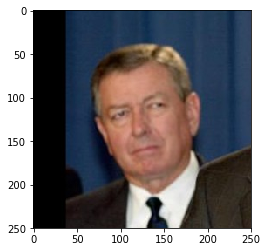

(1, 62, 62, 32)


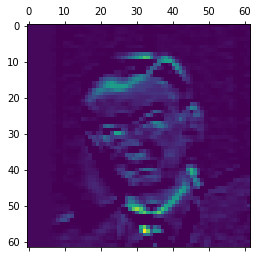

In [0]:
image = cv2.imread('drive/INFO_6105/face/train/John_Ashcroft/John_Ashcroft_0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
    
image = resize_image(image)
image = image.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
image = image.astype('float32') # float32	Single precision float: sign bit, 8 bits exponent, 23 bits mantissa
image /= 255


# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
    # Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    # This will return a list of 5 Numpy arrays:
    # one array per layer activation
activations = activation_model.predict(image)
    
first_layer_activation = activations[0]
print(first_layer_activation.shape) 
    
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()  
    
   

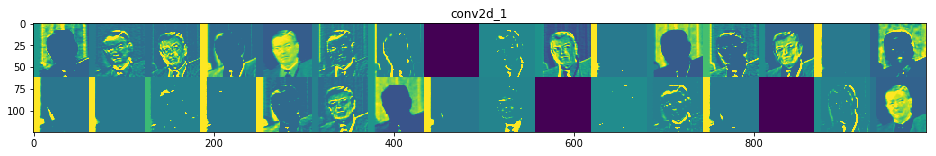

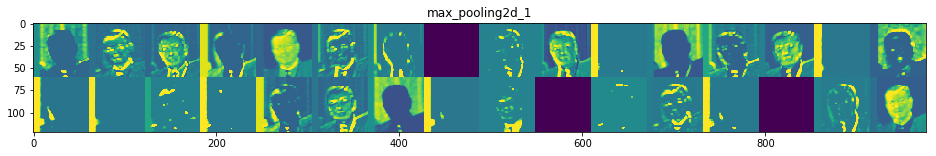

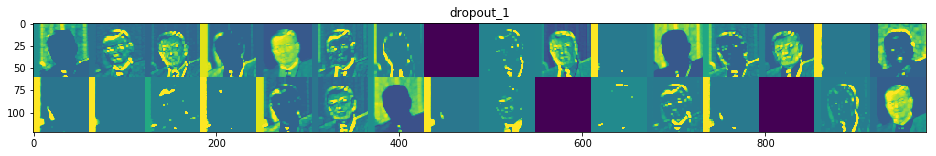

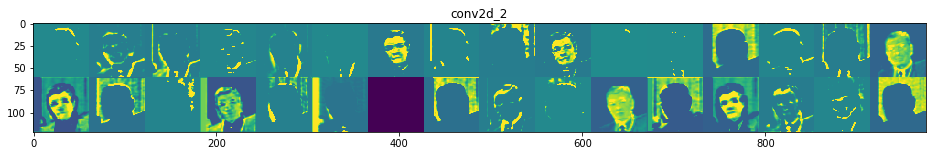

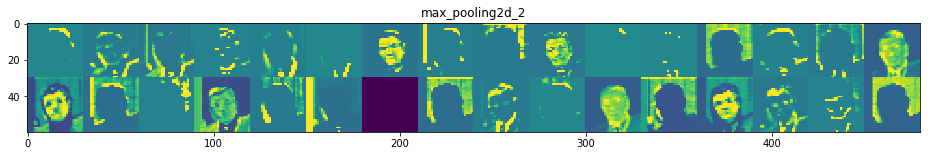

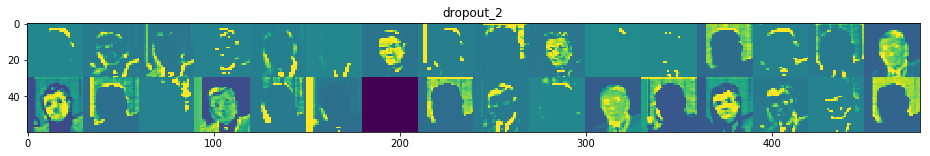

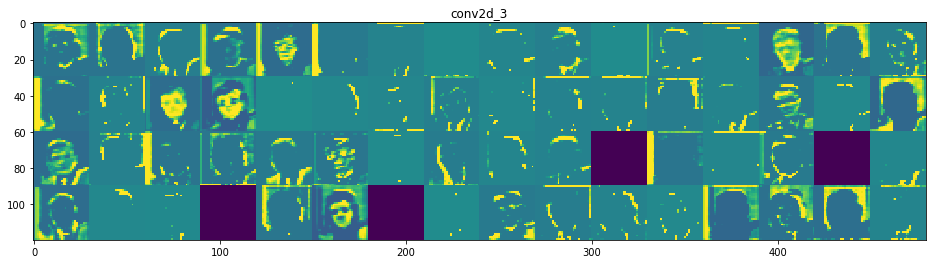

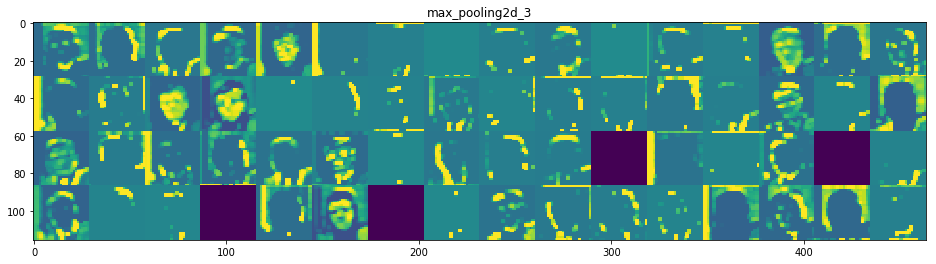

In [0]:
 # These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
    
    # Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    
        # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    
        # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
        # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
        # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
plt.show()
